In [1]:
# import libaries

from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchinfo import summary
from torchvision import transforms
from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold

In [2]:
print('Python version:', sys.version)
print('CUDA Available:', torch.cuda.is_available())

if torch.cuda.is_available():
    print('GPU Name:', torch.cuda.get_device_name())
    print('GPU Properties:\n', torch.cuda.get_device_properties('cuda'))
    device = "cuda"
    torch.cuda.set_per_process_memory_fraction(0.95, 0)
    torch.cuda.empty_cache()
else:
    print("Cuda is not available, please use cpu instead")
    device = "cpu"
!nvidia-smi

Python version: 3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2070
GPU Properties:
 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2070', major=7, minor=5, total_memory=8191MB, multi_processor_count=36)
Sun Feb 19 01:58:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   45C    P2    47W / 175W |    325Mi

In [3]:
seed = 41
# Define custom dataset
class FaceDataset(Dataset):
    def __init__(self, df = None, num_sample = None, transform = None, num_img_pool = 10):
        # set random seed for FaceDataset
        np.random.seed(seed)
        random.seed(seed)
        # create constructors
        self.unique_img_name = None
        self.data = dict()
        self.images = list()
        # label to indices
        self.label_to_indices = dict()
        self.labels = list()
        # read csv file
        self.df = df
        # set the transformation
        self.transform = transform
        # drop last n row from dataframe
        self.df = self.df.head(num_sample)
        #get the length of entire dataset
        self.len_ = len(self.df)
        # load imgs
        self.load_imgs(self.df, num_imgs = num_img_pool, max = num_sample)

    def __len__(self):
        return self.len_

    # get each pair of images -> 1: same identity, 0: different identity
    # if index is even -> same pair
    # if index is odd -> random identity
    def __getitem__(self, idx):
        anchor_img = self.images[idx]
        anchor_label = self.labels[idx]

        pos_idx = np.random.choice(np.arange(len(self.images))[self.labels == anchor_label])
        neg_idx = np.random.choice(np.arange(len(self.images))[self.labels != anchor_label])

        pos_img = self.images[pos_idx]
        neg_img = self.images[neg_idx]

        pos_label = self.labels[pos_idx]
        neg_label = self.labels[neg_idx]

        if self.transform is None:
            img_to_tensor = transforms.ToTensor()
            anchor_img = img_to_tensor(anchor_img)
            pos_img = img_to_tensor(pos_img)
            neg_img = img_to_tensor(neg_img)
        else:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)

        return anchor_img, pos_img, neg_img

    # load imgs from pandas to memory and define the maximum number of images
    def load_imgs(self, df, num_imgs, max):
        # iterate thought each row
        for i, row in tqdm(df.iterrows(), total = max):
            # get identity of each row
            row_identity = row['identity']
            # append each identity to numberical value
            self.label_to_indices[int(row_identity)] = i
            count_img = 0
            # loop imgs in each identity
            for img_name in row['path']:
                if count_img > num_imgs:
                    break
                # concatenate the directoru and image name
                # path_to_image = self.dir+img_name
                path_to_image = img_name
                # open image and convert to RGB
                img = Image.open(path_to_image).convert('RGB')

                self.images.append(img)
                self.labels.append(i)
                count_img += 1
            # print('Added img '+ str(row_identity))
        self.labels = np.array(self.labels)

In [4]:
ds_df = pd.read_csv('./digiface_csv_files/digi_all.csv')
ds_df = ds_df.groupby('identity')['path'].apply(list).reset_index()
ds_df

,identity,path
0,0,"[digiFace1M\subjects_0-1999_72_imgs\0\20.png, ..."
1,1,"[digiFace1M\subjects_0-1999_72_imgs\1\66.png, ..."
2,2,"[digiFace1M\subjects_0-1999_72_imgs\2\29.png, ..."
3,3,"[digiFace1M\subjects_0-1999_72_imgs\3\42.png, ..."
4,4,"[digiFace1M\subjects_0-1999_72_imgs\4\33.png, ..."
...,...,...
72661,199994,[digiFace1M\subjects_166666-199998_5_imgs\1999...
72662,199995,[digiFace1M\subjects_166666-199998_5_imgs\1999...
72663,199996,[digiFace1M\subjects_166666-199998_5_imgs\1999...
72664,199997,[digiFace1M\subjects_166666-199998_5_imgs\1999...


In [5]:
from sklearn.model_selection import train_test_split

# splitting each dataset
train_df, eval_df = train_test_split(ds_df, test_size= 0.3, shuffle = True, random_state = seed)
val_df, test_df = train_test_split(eval_df, test_size = 0.4, shuffle = True, random_state = seed)

# print to check size of each dataset
print(f'Train Size: {len(train_df)}')
print(f'Val Size: {len(val_df)}')
print(f'Test Size: {len(test_df)}')

train_df.head(5)

Train Size: 50866
Val Size: 13080
Test Size: 8720


,identity,path
26344,120344,[digiFace1M\subjects_100000-133332_5_imgs\1203...
61833,189166,[digiFace1M\subjects_166666-199998_5_imgs\1891...
46921,174254,[digiFace1M\subjects_166666-199998_5_imgs\1742...
4873,8873,[digiFace1M\subjects_8000-9999_72_imgs\8873\54...
19875,113875,[digiFace1M\subjects_100000-133332_5_imgs\1138...


In [6]:
# define image size
img_size = 112

# # define transformation for test set
# train_transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.CenterCrop(img_size),
#     transforms.RandomHorizontalFlip(p=0.6),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                          std=[0.5, 0.5, 0.5])
# ])


# # define transformation for validation set
# val_transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.CenterCrop(img_size),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                          std=[0.5, 0.5, 0.5])
# ])


# # define batch size
# train_batch_size = 64
# val_batch_size = 64
# print('------------Started Loading Train Set------------')
# # create dataloader for train set
# train_triplet_dataset = FaceDataset(df = train_df, num_sample = 6000, transform = train_transform)
# train_triplet_dataloader = DataLoader(train_triplet_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)
# print('Total Train Set: ', train_triplet_dataset.__len__())
# print('-----------Finished Loading Train Set------------')

# print('\n')

# print('------------Started Loading Validation Set------------')
# # create dataloader for validation set
# val_triplet_dataset = FaceDataset(df = val_df,num_sample = 3000, transform = val_transform)
# val_triplet_dataloader = DataLoader(val_triplet_dataset, batch_size=val_batch_size, shuffle=True, pin_memory=True)
# print('Total Train Set: ', val_triplet_dataset.__len__())
# print('-----------Finished Loading Validation Set------------')


In [7]:
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, ReLU6, Sigmoid, Dropout2d\
    ,Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter

class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def l2_norm(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

class h_sigmoid(Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = AdaptiveAvgPool2d(1)
        self.fc = Sequential(
            Linear(channel, channel // reduction),
            ReLU(inplace=True),
            Linear(channel // reduction, channel),
            h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class PermutationBlock(Module):
    def __init__(self, groups):
        super(PermutationBlock, self).__init__()
        self.groups = groups

    def forward(self, input):
        n, c, h, w = input.size()
        G = self.groups
        output = input.view(n, G, c // G, h, w).permute(0, 2, 1, 3, 4).contiguous().view(n, c, h, w)
        return output

class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Depth_Wise(Module):
    def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = Conv_block(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
    def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output

class Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)

class LinearScheduler(nn.Module):
    def __init__(self, dropblock, start_value, stop_value, nr_steps):
        super(LinearScheduler, self).__init__()
        self.dropblock = dropblock
        self.i = 0
        self.drop_values = np.linspace(start=start_value, stop=stop_value, num=nr_steps)

    def forward(self, x):
        return self.dropblock(x)

    def step(self):
        if self.i < len(self.drop_values):
            self.dropblock.drop_prob = self.drop_values[self.i]

        self.i += 1

class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)


In [8]:

class MobileFaceNet(Module):
    def __init__(self, embedding_size=512):
        super(MobileFaceNet, self).__init__()
        self.conv1 = Conv_block(3, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        self.conv_23 = Depth_Wise(64, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128)
        self.conv_3 = Residual(64, num_block=4, groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        self.conv_4 = Residual(128, num_block=6, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512)
        self.conv_5 = Residual(128, num_block=2, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups=512, kernel=(7,7), stride=(1, 1), padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias=False)
        self.bn = BatchNorm1d(embedding_size)
        self.dropblock = DropBlock2D(block_size=3, drop_prob=0.3)
        self.dropout = Dropout2d(0.1)

    def forward_once(self,x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)

        out = self.conv_34(out)

        out = self.conv_4(out)

        # out = self.dropblock(out)

        out = self.conv_45(out)

        out = self.conv_5(out)

        out = self.conv_6_sep(out)

        out = self.dropblock(out)

        out = self.conv_6_dw(out)

        out = self.dropblock(out)

        out = self.conv_6_flatten(out)

        out = self.linear(out)

        out = self.bn(out)
        return l2_norm(out)

    def forward(self, anchor_img, positive_img, negative_img):
        anchor = self.forward_once(anchor_img)
        positive = self.forward_once(positive_img)
        negative = self.forward_once(negative_img)
        return anchor, positive, negative


In [9]:
# triplet_model = TripletNetwork()
triplet_model = MobileFaceNet()
print(summary(triplet_model, input_size=[(32,3,112,112),(32,3,112,112),(32,3,112,112)]))

Layer (type:depth-idx)                        Output Shape              Param #
MobileFaceNet                                 [32, 512]                 --
├─Conv_block: 1-1                             [32, 64, 56, 56]          --
│    └─Conv2d: 2-1                            [32, 64, 56, 56]          1,728
│    └─BatchNorm2d: 2-2                       [32, 64, 56, 56]          128
│    └─PReLU: 2-3                             [32, 64, 56, 56]          64
├─Conv_block: 1-2                             [32, 64, 56, 56]          --
│    └─Conv2d: 2-4                            [32, 64, 56, 56]          576
│    └─BatchNorm2d: 2-5                       [32, 64, 56, 56]          128
│    └─PReLU: 2-6                             [32, 64, 56, 56]          64
├─Depth_Wise: 1-3                             [32, 64, 28, 28]          --
│    └─Conv_block: 2-7                        [32, 128, 56, 56]         --
│    │    └─Conv2d: 3-1                       [32, 128, 56, 56]         8,192
│    │    └

In [10]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        # calculate Euclidean's distance
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        # distance_positive = F.pairwise_distance(anchor, positive).view((-1, 1))
        # distance_negative = F.pairwise_distance(anchor, negative).view((-1, 1))
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return torch.mean(losses)

In [11]:
def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))

    acc = float(tp + tn) / dist.size

    return acc

In [12]:
model_config = {
    'margin': 1.2,
    'lr': 1e-3,
    'patience': 5,
    'factor': 0.1,
    'min_lr': 1e-10,
    'threshold': 1e-3
}
criterion = TripletLoss(margin = model_config['margin'])
optimizer = optim.Adam(triplet_model.parameters(), lr=model_config['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=model_config['patience'], factor=model_config['factor'], min_lr=model_config['min_lr'], threshold=model_config['threshold'], verbose=True)

In [13]:
from statistics import mean

def train_model(model, train_loader, train_optimizer, train_criterion):
    train_loss = 0
    train_accuracy = list()
    # set to train mode
    model.train()
    # enable grad
    with torch.set_grad_enabled(True):
        # loop though loader
        for anchor_img, pos_img, neg_img in train_loader:
            # for calculate accuracy
            threshold_list = np.full(anchor_img.shape[0], model_config['margin'])
            is_same = np.full(anchor_img.shape[0], 1)

            # throw img to CUDA
            anchor_img, pos_img,neg_img = anchor_img.to(device), pos_img.to(device),neg_img.to(device)
            # prevent grad vansishing
            train_optimizer.zero_grad()
            # training model
            anchor_img, pos_img, neg_img = model(anchor_img, pos_img,neg_img)
            # calculate loss
            loss = train_criterion(anchor_img, pos_img, neg_img)
            # backpropragation
            loss.backward()
            # compute gradient
            train_optimizer.step()
            # compute train loss
            train_loss += loss.item() * anchor_img.size(0)
            # calculate distance
            distance_positive = (anchor_img - pos_img).pow(2).sum(1)
            # compute accuracy
            train_accuracy.append(calculate_accuracy(threshold_list,distance_positive.cpu().data.numpy(),is_same))

    return  train_loss, mean(train_accuracy)

def test_model(model, test_loader, test_optimizer, test_criterion, weight_path = None):
    test_loss = 0
    test_accuracy = list()
    if weight_path != None: 
        model.load_state_dict(torch.load(weight_path))
    # set to train mode
    model.eval()
    # enable grad
    with torch.no_grad():
        # loop though loader
        for anchor_img, pos_img, neg_img in test_loader:
            # for calculate accuracy
            threshold_list = np.full(anchor_img.shape[0], model_config['margin'])
            is_same = np.full(anchor_img.shape[0], 1)

            # throw img to CUDA
            anchor_img, pos_img,neg_img = anchor_img.to(device), pos_img.to(device),neg_img.to(device)
            # training model
            anchor_img, pos_img, neg_img = model(anchor_img, pos_img,neg_img)
            # calculate loss
            loss = test_criterion(anchor_img, pos_img, neg_img)
            test_optimizer.zero_grad()
            # compute train loss
            test_loss += loss.item() * anchor_img.size(0)
            # calculate distance
            distance_positive = (anchor_img - pos_img).pow(2).sum(1)
            # compute accuracy
            test_accuracy.append(calculate_accuracy(threshold_list,distance_positive.cpu().data.numpy(),is_same))

    return test_loss, mean(test_accuracy)


In [14]:
# num_epoch = 120
# previous_lr = 0
# save_weight_path = './weights/triplet_mobilenetwork_120_epochs.pth'
# history_train = {
#     'train_loss': list(),
#     'val_loss': list(),
#     'train_acc': list(),
#     'val_acc': list()
# }
# triplet_model.to(device)
# for epoch in tqdm(range(num_epoch)):
#     # train model
#     epoch_train_loss, train_acc = train_model(triplet_model, train_triplet_dataloader, optimizer, criterion)
#     # validate model
#     epoch_val_loss, val_acc = test_model(triplet_model, val_triplet_dataloader, optimizer, criterion)
#     # compute loss
#     train_loss = epoch_train_loss / len(train_triplet_dataloader.sampler)
#     val_loss = epoch_val_loss / len(val_triplet_dataloader.sampler)
#     # update scheduler
#     scheduler.step(train_loss)

#     # append historical data
#     history_train['train_loss'].append(train_loss)
#     history_train['val_loss'].append(val_loss)

#     history_train['train_acc'].append(train_acc)
#     history_train['val_acc'].append(val_acc)

#     # get the learning rate
#     optim_lr = optimizer.param_groups[0]['lr']
#     if (optim_lr < previous_lr) | (optim_lr > previous_lr):
#         print('LEARNING RATE HAS CHANGED!')
#     # update learning rate to temp variable
#     previous_lr = optim_lr
#     # observe status
#     print(f'Epoch {epoch+1}/{num_epoch},Learning rate: {optim_lr}, train loss: {round(train_loss,5)}, valid loss: {round(val_loss,5)}, train acc: {round(train_acc,5)}, valid acc: {round(val_acc,5)}')

# # save model weight
# torch.save(triplet_model.state_dict(), save_weight_path)
# # clear GPU memory allocated
# torch.cuda.empty_cache()

In [15]:
# plt.plot(np.arange(1,len(history_train['train_loss'])+1), history_train['train_loss'],label = 'Train Loss')
# plt.plot(np.arange(1,len(history_train['val_loss'])+1),history_train['val_loss'], label= 'Validation loss')
# plt.legend()
# plt.show()

In [16]:
# plt.plot(np.arange(1,len(history_train['train_acc'])+1), history_train['train_acc'],label = 'Train acc')
# plt.plot(np.arange(1,len(history_train['val_acc'])+1),history_train['val_acc'], label= 'Validation acc')
# plt.legend()
# plt.show()

In [17]:
# plt.plot(np.arange(1,len(history_train['train_loss'])+1), history_train['train_loss'],label = 'Train Loss')
# plt.plot(np.arange(1,len(history_train['val_loss'])+1),history_train['val_loss'], label= 'Validation loss')
# plt.plot(np.arange(1,len(history_train['train_acc'])+1), history_train['train_acc'],label = 'Train acc')
# plt.plot(np.arange(1,len(history_train['val_acc'])+1),history_train['val_acc'], label= 'Validation acc')
# plt.legend()
# plt.show()

In [18]:
# torch.cuda.empty_cache()

In [19]:
# define transformation for test set
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.6),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])
# define transformation for validation set
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])
cross_val_train_dataset = FaceDataset(df = train_df, num_sample = 10000, transform = train_transform)
cross_val_val_dataset = FaceDataset(df = val_df, num_sample = 10000, transform = val_transform)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
num_epoch = 130
previous_lr = 0
history_train = {
    'train_loss': dict(),
    'val_loss': dict(),
    'train_acc': dict(),
    'val_acc': dict()
}
split = 5
k_fold = KFold(n_splits = split, shuffle = True, random_state=seed)
batch_size = 64
for fold, (train_idx, valid_idx) in tqdm(enumerate(k_fold.split(cross_val_train_dataset)),total = split):

    triplet_model = MobileFaceNet()
    
    triplet_model.to(device)
    model_config = {
    'margin': 1.2,
    'lr': 1e-3,
    'patience': 5,
    'factor': 0.1,
    'min_lr': 1e-10,
    'threshold': 1e-3
    }
    criterion = TripletLoss(margin = model_config['margin'])
    optimizer = optim.Adam(triplet_model.parameters(), lr=model_config['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=model_config['patience'], factor=model_config['factor'], min_lr=model_config['min_lr'], threshold=model_config['threshold'], verbose=True)
    print(f'Fold: {fold}/{split}')

    # the number of epoch in each fold
    # Random get the sample from dataset
    train_subsampler = torch.utils.data.Subset(cross_val_train_dataset,train_idx)
    valid_subsampler = torch.utils.data.Subset(cross_val_val_dataset,valid_idx)

    # Load data into dataloader
    train_loader = DataLoader(train_subsampler, batch_size = batch_size,  shuffle = True,pin_memory=True)
    valid_loader = DataLoader(valid_subsampler, batch_size = batch_size, shuffle = True, pin_memory=True)
    
    hist_epoch_train_loss = list()
    hist_epoch_val_loss = list()
    hist_epoch_train_acc = list()
    hist_epoch_val_acc = list()
    
    for epoch in tqdm(range(num_epoch)):
        # train model
        epoch_train_loss, train_acc = train_model(triplet_model, train_loader, optimizer, criterion)
        # validate model
        epoch_val_loss, val_acc = test_model(triplet_model, valid_loader, optimizer, criterion)
        # compute loss
        train_loss = epoch_train_loss / len(train_loader.sampler)
        val_loss = epoch_val_loss / len(valid_loader.sampler)
        # update scheduler
        scheduler.step(train_loss)
        
        hist_epoch_train_loss.append(train_loss)
        hist_epoch_val_loss.append(val_loss)
        
        hist_epoch_train_acc.append(train_acc)
        hist_epoch_val_acc.append(val_acc)

        # get the learning rate
        optim_lr = optimizer.param_groups[0]['lr']
        if (optim_lr < previous_lr) | (optim_lr > previous_lr):
            print('LEARNING RATE HAS CHANGED!')
        # update learning rate to temp variable
        previous_lr = optim_lr
        # observe status
        print(f'Fold: {fold+1}/{split}, Epoch {epoch+1}/{num_epoch},Learning rate: {optim_lr}, train loss: {round(train_loss,5)}, valid loss: {round(val_loss,5)}, train acc: {round(train_acc,5)}, val acc: {round(val_acc,5)}')
    
    # append historical data
    history_train['train_loss'][fold] = hist_epoch_train_loss
    history_train['val_loss'][fold] = hist_epoch_val_loss

    history_train['train_acc'][fold] = hist_epoch_train_acc
    history_train['val_acc'][fold] = hist_epoch_val_acc
    
    print(f'Average result {fold+1}/{split}, Avg train loss:', mean(history_train['train_loss'][fold]), 'Avg Val loss:',mean(history_train['val_loss'][fold]),'avg train acc:', mean(history_train['train_acc'][fold]), 'avg val acc:', mean(history_train['val_acc'][fold]) )
    # clear GPU memory allocated
    torch.cuda.empty_cache()

  0%|          | 0/5 [00:00<?, ?it/s]

Fold: 0/5


  0%|          | 0/130 [00:00<?, ?it/s]

LEARNING RATE HAS CHANGED!
Fold: 1/5, Epoch 1/130,Learning rate: 0.001, train loss: 0.72685, valid loss: 0.59401, train acc: 0.47387, val acc: 0.65674
Fold: 1/5, Epoch 2/130,Learning rate: 0.001, train loss: 0.57736, valid loss: 0.45611, train acc: 0.66, val acc: 0.7749
Fold: 1/5, Epoch 3/130,Learning rate: 0.001, train loss: 0.49684, valid loss: 0.44959, train acc: 0.72288, val acc: 0.77441
Fold: 1/5, Epoch 4/130,Learning rate: 0.001, train loss: 0.46956, valid loss: 0.41976, train acc: 0.75262, val acc: 0.82959
Fold: 1/5, Epoch 5/130,Learning rate: 0.001, train loss: 0.46012, valid loss: 0.41437, train acc: 0.74825, val acc: 0.7793
Fold: 1/5, Epoch 6/130,Learning rate: 0.001, train loss: 0.41456, valid loss: 0.38911, train acc: 0.77863, val acc: 0.79834
Fold: 1/5, Epoch 7/130,Learning rate: 0.001, train loss: 0.40763, valid loss: 0.35464, train acc: 0.78625, val acc: 0.83496
Fold: 1/5, Epoch 8/130,Learning rate: 0.001, train loss: 0.38028, valid loss: 0.3573, train acc: 0.80012, val 

Fold: 1/5, Epoch 66/130,Learning rate: 1e-05, train loss: 0.16696, valid loss: 0.17329, train acc: 0.94375, val acc: 0.91553
Fold: 1/5, Epoch 67/130,Learning rate: 1e-05, train loss: 0.16485, valid loss: 0.18914, train acc: 0.94463, val acc: 0.90186
Epoch 00068: reducing learning rate of group 0 to 1.0000e-06.
LEARNING RATE HAS CHANGED!
Fold: 1/5, Epoch 68/130,Learning rate: 1.0000000000000002e-06, train loss: 0.1664, valid loss: 0.19199, train acc: 0.94288, val acc: 0.91846
Fold: 1/5, Epoch 69/130,Learning rate: 1.0000000000000002e-06, train loss: 0.17211, valid loss: 0.19509, train acc: 0.94025, val acc: 0.90723
Fold: 1/5, Epoch 70/130,Learning rate: 1.0000000000000002e-06, train loss: 0.16278, valid loss: 0.19789, train acc: 0.94312, val acc: 0.91309
Fold: 1/5, Epoch 71/130,Learning rate: 1.0000000000000002e-06, train loss: 0.16344, valid loss: 0.19794, train acc: 0.94612, val acc: 0.90625
Fold: 1/5, Epoch 72/130,Learning rate: 1.0000000000000002e-06, train loss: 0.16713, valid loss

Fold: 1/5, Epoch 123/130,Learning rate: 1.0000000000000004e-08, train loss: 0.1649, valid loss: 0.18303, train acc: 0.94212, val acc: 0.9209
Fold: 1/5, Epoch 124/130,Learning rate: 1.0000000000000004e-08, train loss: 0.16491, valid loss: 0.17824, train acc: 0.9425, val acc: 0.9209
Fold: 1/5, Epoch 125/130,Learning rate: 1.0000000000000004e-08, train loss: 0.16846, valid loss: 0.19793, train acc: 0.94312, val acc: 0.90918
Fold: 1/5, Epoch 126/130,Learning rate: 1.0000000000000004e-08, train loss: 0.16682, valid loss: 0.19585, train acc: 0.94688, val acc: 0.91797
Fold: 1/5, Epoch 127/130,Learning rate: 1.0000000000000004e-08, train loss: 0.16514, valid loss: 0.16906, train acc: 0.94363, val acc: 0.92383
Fold: 1/5, Epoch 128/130,Learning rate: 1.0000000000000004e-08, train loss: 0.15904, valid loss: 0.18838, train acc: 0.94975, val acc: 0.91748
Fold: 1/5, Epoch 129/130,Learning rate: 1.0000000000000004e-08, train loss: 0.16376, valid loss: 0.18875, train acc: 0.943, val acc: 0.91602
Fold:

  0%|          | 0/130 [00:00<?, ?it/s]

LEARNING RATE HAS CHANGED!
Fold: 2/5, Epoch 1/130,Learning rate: 0.001, train loss: 0.73877, valid loss: 0.60397, train acc: 0.47563, val acc: 0.65918
Fold: 2/5, Epoch 2/130,Learning rate: 0.001, train loss: 0.58098, valid loss: 0.50373, train acc: 0.66075, val acc: 0.70752
Fold: 2/5, Epoch 3/130,Learning rate: 0.001, train loss: 0.52671, valid loss: 0.43893, train acc: 0.69212, val acc: 0.75537
Fold: 2/5, Epoch 4/130,Learning rate: 0.001, train loss: 0.48417, valid loss: 0.46843, train acc: 0.73425, val acc: 0.76758
Fold: 2/5, Epoch 5/130,Learning rate: 0.001, train loss: 0.45029, valid loss: 0.43257, train acc: 0.74925, val acc: 0.76904
Fold: 2/5, Epoch 6/130,Learning rate: 0.001, train loss: 0.42861, valid loss: 0.41082, train acc: 0.76675, val acc: 0.78027
Fold: 2/5, Epoch 7/130,Learning rate: 0.001, train loss: 0.40634, valid loss: 0.41107, train acc: 0.77112, val acc: 0.79004
Fold: 2/5, Epoch 8/130,Learning rate: 0.001, train loss: 0.4003, valid loss: 0.36848, train acc: 0.78887,

Fold: 2/5, Epoch 66/130,Learning rate: 0.0001, train loss: 0.16507, valid loss: 0.1964, train acc: 0.94263, val acc: 0.90723
Fold: 2/5, Epoch 67/130,Learning rate: 0.0001, train loss: 0.16275, valid loss: 0.2083, train acc: 0.94675, val acc: 0.90918
Fold: 2/5, Epoch 68/130,Learning rate: 0.0001, train loss: 0.16072, valid loss: 0.19613, train acc: 0.94712, val acc: 0.91797
Fold: 2/5, Epoch 69/130,Learning rate: 0.0001, train loss: 0.1615, valid loss: 0.19703, train acc: 0.94875, val acc: 0.91309
Fold: 2/5, Epoch 70/130,Learning rate: 0.0001, train loss: 0.15599, valid loss: 0.21072, train acc: 0.949, val acc: 0.91504
Fold: 2/5, Epoch 71/130,Learning rate: 0.0001, train loss: 0.16212, valid loss: 0.18712, train acc: 0.94625, val acc: 0.92578
Fold: 2/5, Epoch 72/130,Learning rate: 0.0001, train loss: 0.16248, valid loss: 0.1897, train acc: 0.94637, val acc: 0.91602
Fold: 2/5, Epoch 73/130,Learning rate: 0.0001, train loss: 0.15757, valid loss: 0.18616, train acc: 0.94837, val acc: 0.9091

Fold: 2/5, Epoch 126/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13915, valid loss: 0.1951, train acc: 0.95975, val acc: 0.91455
Fold: 2/5, Epoch 127/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13885, valid loss: 0.20277, train acc: 0.96062, val acc: 0.91162
Fold: 2/5, Epoch 128/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14475, valid loss: 0.1849, train acc: 0.95925, val acc: 0.92285
Fold: 2/5, Epoch 129/130,Learning rate: 1.0000000000000004e-08, train loss: 0.1377, valid loss: 0.19973, train acc: 0.95925, val acc: 0.92529
Fold: 2/5, Epoch 130/130,Learning rate: 1.0000000000000004e-08, train loss: 0.13953, valid loss: 0.18913, train acc: 0.95813, val acc: 0.91748
Average result 2/5, Avg train loss: 0.21472725257323338 Avg Val loss: 0.23697318682670593 avg train acc: 0.9105192307692308 avg val acc: 0.8923414963942308
Fold: 2/5


  0%|          | 0/130 [00:00<?, ?it/s]

LEARNING RATE HAS CHANGED!
Fold: 3/5, Epoch 1/130,Learning rate: 0.001, train loss: 0.72685, valid loss: 0.61314, train acc: 0.4745, val acc: 0.66992
Fold: 3/5, Epoch 2/130,Learning rate: 0.001, train loss: 0.55685, valid loss: 0.51113, train acc: 0.66287, val acc: 0.71338
Fold: 3/5, Epoch 3/130,Learning rate: 0.001, train loss: 0.50312, valid loss: 0.49166, train acc: 0.70375, val acc: 0.77734
Fold: 3/5, Epoch 4/130,Learning rate: 0.001, train loss: 0.47161, valid loss: 0.44786, train acc: 0.73213, val acc: 0.79541
Fold: 3/5, Epoch 5/130,Learning rate: 0.001, train loss: 0.45543, valid loss: 0.41235, train acc: 0.751, val acc: 0.79883
Fold: 3/5, Epoch 6/130,Learning rate: 0.001, train loss: 0.42343, valid loss: 0.39945, train acc: 0.76675, val acc: 0.82861
Fold: 3/5, Epoch 7/130,Learning rate: 0.001, train loss: 0.40024, valid loss: 0.36124, train acc: 0.78725, val acc: 0.81494
Fold: 3/5, Epoch 8/130,Learning rate: 0.001, train loss: 0.38099, valid loss: 0.36666, train acc: 0.80488, v

Fold: 3/5, Epoch 66/130,Learning rate: 0.0001, train loss: 0.16605, valid loss: 0.1869, train acc: 0.9415, val acc: 0.9248
Fold: 3/5, Epoch 67/130,Learning rate: 0.0001, train loss: 0.15756, valid loss: 0.19874, train acc: 0.94763, val acc: 0.92041
Fold: 3/5, Epoch 68/130,Learning rate: 0.0001, train loss: 0.16663, valid loss: 0.19611, train acc: 0.94475, val acc: 0.92139
Epoch 00069: reducing learning rate of group 0 to 1.0000e-05.
LEARNING RATE HAS CHANGED!
Fold: 3/5, Epoch 69/130,Learning rate: 1e-05, train loss: 0.16453, valid loss: 0.17893, train acc: 0.946, val acc: 0.92139
Fold: 3/5, Epoch 70/130,Learning rate: 1e-05, train loss: 0.15574, valid loss: 0.20057, train acc: 0.94988, val acc: 0.92773
Fold: 3/5, Epoch 71/130,Learning rate: 1e-05, train loss: 0.15576, valid loss: 0.1798, train acc: 0.95, val acc: 0.92383
Fold: 3/5, Epoch 72/130,Learning rate: 1e-05, train loss: 0.15338, valid loss: 0.20087, train acc: 0.95525, val acc: 0.91895
Fold: 3/5, Epoch 73/130,Learning rate: 1e-

Fold: 3/5, Epoch 123/130,Learning rate: 1.0000000000000004e-08, train loss: 0.15611, valid loss: 0.18859, train acc: 0.9455, val acc: 0.92725
Fold: 3/5, Epoch 124/130,Learning rate: 1.0000000000000004e-08, train loss: 0.15165, valid loss: 0.19155, train acc: 0.9545, val acc: 0.92236
Fold: 3/5, Epoch 125/130,Learning rate: 1.0000000000000004e-08, train loss: 0.15269, valid loss: 0.17921, train acc: 0.9525, val acc: 0.9248
Fold: 3/5, Epoch 126/130,Learning rate: 1.0000000000000004e-08, train loss: 0.15931, valid loss: 0.19177, train acc: 0.95125, val acc: 0.92188
Fold: 3/5, Epoch 127/130,Learning rate: 1.0000000000000004e-08, train loss: 0.15179, valid loss: 0.19556, train acc: 0.94837, val acc: 0.92383
Fold: 3/5, Epoch 128/130,Learning rate: 1.0000000000000004e-08, train loss: 0.15097, valid loss: 0.18727, train acc: 0.95012, val acc: 0.91797
Fold: 3/5, Epoch 129/130,Learning rate: 1.0000000000000004e-08, train loss: 0.15167, valid loss: 0.19948, train acc: 0.9515, val acc: 0.91992
Fold

  0%|          | 0/130 [00:00<?, ?it/s]

LEARNING RATE HAS CHANGED!
Fold: 4/5, Epoch 1/130,Learning rate: 0.001, train loss: 0.74831, valid loss: 0.5462, train acc: 0.48438, val acc: 0.69434
Fold: 4/5, Epoch 2/130,Learning rate: 0.001, train loss: 0.59011, valid loss: 0.51618, train acc: 0.64787, val acc: 0.68994
Fold: 4/5, Epoch 3/130,Learning rate: 0.001, train loss: 0.51758, valid loss: 0.44668, train acc: 0.69275, val acc: 0.7832
Fold: 4/5, Epoch 4/130,Learning rate: 0.001, train loss: 0.48089, valid loss: 0.4619, train acc: 0.73638, val acc: 0.79736
Fold: 4/5, Epoch 5/130,Learning rate: 0.001, train loss: 0.45237, valid loss: 0.43394, train acc: 0.74975, val acc: 0.78809
Fold: 4/5, Epoch 6/130,Learning rate: 0.001, train loss: 0.42187, valid loss: 0.38205, train acc: 0.76787, val acc: 0.81836
Fold: 4/5, Epoch 7/130,Learning rate: 0.001, train loss: 0.40344, valid loss: 0.35806, train acc: 0.78138, val acc: 0.84717
Fold: 4/5, Epoch 8/130,Learning rate: 0.001, train loss: 0.38634, valid loss: 0.32339, train acc: 0.79937, v

Fold: 4/5, Epoch 67/130,Learning rate: 0.0001, train loss: 0.15863, valid loss: 0.17668, train acc: 0.953, val acc: 0.93799
Fold: 4/5, Epoch 68/130,Learning rate: 0.0001, train loss: 0.15729, valid loss: 0.19553, train acc: 0.94912, val acc: 0.93213
Fold: 4/5, Epoch 69/130,Learning rate: 0.0001, train loss: 0.15994, valid loss: 0.18911, train acc: 0.94737, val acc: 0.92822
Fold: 4/5, Epoch 70/130,Learning rate: 0.0001, train loss: 0.15446, valid loss: 0.16038, train acc: 0.94875, val acc: 0.94189
Fold: 4/5, Epoch 71/130,Learning rate: 0.0001, train loss: 0.15538, valid loss: 0.16418, train acc: 0.95275, val acc: 0.94336
Epoch 00072: reducing learning rate of group 0 to 1.0000e-05.
LEARNING RATE HAS CHANGED!
Fold: 4/5, Epoch 72/130,Learning rate: 1e-05, train loss: 0.15996, valid loss: 0.17456, train acc: 0.9505, val acc: 0.9292
Fold: 4/5, Epoch 73/130,Learning rate: 1e-05, train loss: 0.15668, valid loss: 0.18519, train acc: 0.94963, val acc: 0.93408
Fold: 4/5, Epoch 74/130,Learning ra

Fold: 4/5, Epoch 125/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14911, valid loss: 0.16624, train acc: 0.95212, val acc: 0.93213
Fold: 4/5, Epoch 126/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14596, valid loss: 0.1694, train acc: 0.95675, val acc: 0.93652
Fold: 4/5, Epoch 127/130,Learning rate: 1.0000000000000004e-08, train loss: 0.14829, valid loss: 0.16623, train acc: 0.95713, val acc: 0.93652
Fold: 4/5, Epoch 128/130,Learning rate: 1.0000000000000004e-08, train loss: 0.148, valid loss: 0.18897, train acc: 0.95475, val acc: 0.92529
Fold: 4/5, Epoch 129/130,Learning rate: 1.0000000000000004e-08, train loss: 0.15482, valid loss: 0.17435, train acc: 0.9525, val acc: 0.93506
Fold: 4/5, Epoch 130/130,Learning rate: 1.0000000000000004e-08, train loss: 0.15161, valid loss: 0.19688, train acc: 0.95163, val acc: 0.9248
Average result 4/5, Avg train loss: 0.21153148956573928 Avg Val loss: 0.2180221122656877 avg train acc: 0.9117403846153846 avg val acc: 0.909675480

  0%|          | 0/130 [00:00<?, ?it/s]

LEARNING RATE HAS CHANGED!
Fold: 5/5, Epoch 1/130,Learning rate: 0.001, train loss: 0.74229, valid loss: 0.59256, train acc: 0.48988, val acc: 0.68555
Fold: 5/5, Epoch 2/130,Learning rate: 0.001, train loss: 0.5851, valid loss: 0.53309, train acc: 0.6525, val acc: 0.73975
Fold: 5/5, Epoch 3/130,Learning rate: 0.001, train loss: 0.52134, valid loss: 0.45203, train acc: 0.707, val acc: 0.76416
Fold: 5/5, Epoch 4/130,Learning rate: 0.001, train loss: 0.46599, valid loss: 0.39518, train acc: 0.74162, val acc: 0.7998
Fold: 5/5, Epoch 5/130,Learning rate: 0.001, train loss: 0.44244, valid loss: 0.42629, train acc: 0.7625, val acc: 0.76123
Fold: 5/5, Epoch 6/130,Learning rate: 0.001, train loss: 0.42714, valid loss: 0.35757, train acc: 0.76975, val acc: 0.8208
Fold: 5/5, Epoch 7/130,Learning rate: 0.001, train loss: 0.40274, valid loss: 0.36386, train acc: 0.77763, val acc: 0.82715
Fold: 5/5, Epoch 8/130,Learning rate: 0.001, train loss: 0.39178, valid loss: 0.3832, train acc: 0.79363, val ac

Fold: 5/5, Epoch 67/130,Learning rate: 0.001, train loss: 0.19853, valid loss: 0.20965, train acc: 0.92563, val acc: 0.91504
Fold: 5/5, Epoch 68/130,Learning rate: 0.001, train loss: 0.18108, valid loss: 0.21287, train acc: 0.93075, val acc: 0.90771
Fold: 5/5, Epoch 69/130,Learning rate: 0.001, train loss: 0.17298, valid loss: 0.21288, train acc: 0.94175, val acc: 0.90137
Fold: 5/5, Epoch 70/130,Learning rate: 0.001, train loss: 0.17999, valid loss: 0.22833, train acc: 0.933, val acc: 0.90723
Fold: 5/5, Epoch 71/130,Learning rate: 0.001, train loss: 0.18134, valid loss: 0.21578, train acc: 0.93575, val acc: 0.90332
Fold: 5/5, Epoch 72/130,Learning rate: 0.001, train loss: 0.17712, valid loss: 0.21345, train acc: 0.93712, val acc: 0.90674
Fold: 5/5, Epoch 73/130,Learning rate: 0.001, train loss: 0.18784, valid loss: 0.20257, train acc: 0.93688, val acc: 0.91895
Fold: 5/5, Epoch 74/130,Learning rate: 0.001, train loss: 0.17977, valid loss: 0.21187, train acc: 0.937, val acc: 0.9126
Fold:

In [23]:
torch.cuda.empty_cache()

In [ ]:
# save_weight_path = './weights/triplet_mobilenetwork_120_epochs_updated.pth'
# torch.save(triplet_model.state_dict(), save_weight_path)

In [25]:
avg_train_loss = list()
avg_val_loss = list()
avg_train_acc = list()
avg_val_acc = list()

for i in range(split): 

    avg_train_loss.extend(history_train['train_loss'][i])
    avg_val_loss.extend(history_train['val_loss'][i])
    avg_train_acc.extend(history_train['train_acc'][i])
    avg_val_acc.extend(history_train['val_acc'][i])

# print(mean(avg_train_loss))
print(f'avg train loss: {round(mean(avg_train_loss),4)}, avg val loss: {round(mean(avg_val_loss),4)}, avg train acc: {round(mean(avg_train_acc),4)}, avg val acc: {round(mean(avg_val_acc),4)}')

avg train loss: 0.2146, avg val loss: 0.2292, avg train acc: 0.9099, avg val acc: 0.8992


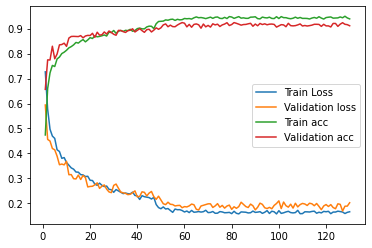

In [26]:
plt.plot(np.arange(1,len(history_train['train_loss'][0])+1), history_train['train_loss'][0],label = 'Train Loss')
plt.plot(np.arange(1,len(history_train['val_loss'][0])+1),history_train['val_loss'][0], label= 'Validation loss')
plt.plot(np.arange(1,len(history_train['train_acc'][0])+1), history_train['train_acc'][0],label = 'Train acc')
plt.plot(np.arange(1,len(history_train['val_acc'][0])+1),history_train['val_acc'][0], label= 'Validation acc')
plt.legend()
plt.show()

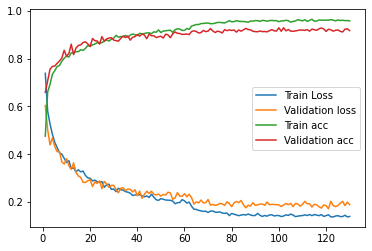

In [27]:
plt.plot(np.arange(1,len(history_train['train_loss'][1])+1), history_train['train_loss'][1],label = 'Train Loss')
plt.plot(np.arange(1,len(history_train['val_loss'][1])+1),history_train['val_loss'][1], label= 'Validation loss')
plt.plot(np.arange(1,len(history_train['train_acc'][1])+1), history_train['train_acc'][1],label = 'Train acc')
plt.plot(np.arange(1,len(history_train['val_acc'][1])+1),history_train['val_acc'][1], label= 'Validation acc')
plt.legend()
plt.show()

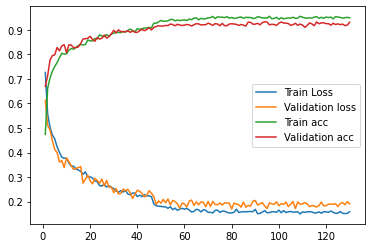

In [28]:
plt.plot(np.arange(1,len(history_train['train_loss'][2])+1), history_train['train_loss'][2],label = 'Train Loss')
plt.plot(np.arange(1,len(history_train['val_loss'][2])+1),history_train['val_loss'][2], label= 'Validation loss')
plt.plot(np.arange(1,len(history_train['train_acc'][2])+1), history_train['train_acc'][2],label = 'Train acc')
plt.plot(np.arange(1,len(history_train['val_acc'][2])+1),history_train['val_acc'][2], label= 'Validation acc')
plt.legend()
plt.show()

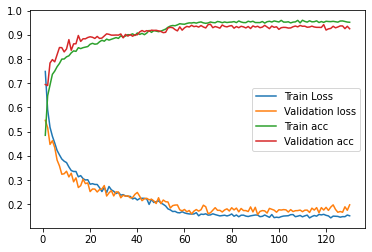

In [29]:
plt.plot(np.arange(1,len(history_train['train_loss'][3])+1), history_train['train_loss'][3],label = 'Train Loss')
plt.plot(np.arange(1,len(history_train['val_loss'][3])+1),history_train['val_loss'][3], label= 'Validation loss')
plt.plot(np.arange(1,len(history_train['train_acc'][3])+1), history_train['train_acc'][3],label = 'Train acc')
plt.plot(np.arange(1,len(history_train['val_acc'][3])+1),history_train['val_acc'][3], label= 'Validation acc')
plt.legend()
plt.show()

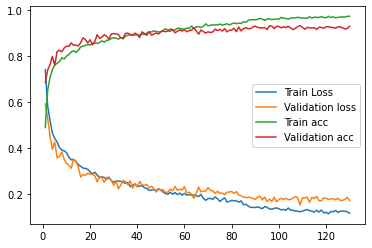

In [30]:
plt.plot(np.arange(1,len(history_train['train_loss'][4])+1), history_train['train_loss'][4],label = 'Train Loss')
plt.plot(np.arange(1,len(history_train['val_loss'][4])+1),history_train['val_loss'][4], label= 'Validation loss')
plt.plot(np.arange(1,len(history_train['train_acc'][4])+1), history_train['train_acc'][4],label = 'Train acc')
plt.plot(np.arange(1,len(history_train['val_acc'][4])+1),history_train['val_acc'][4], label= 'Validation acc')
plt.legend()
plt.show()

In [31]:

# define batch size for testing
test_batch_size = 64
# create dataloader for validation set
test_triplet_dataset = FaceDataset(df = val_df, num_sample = 3000)
test_triplet_dataloader = DataLoader(test_triplet_dataset, batch_size=test_batch_size, shuffle=True, pin_memory=True)


  0%|          | 0/3000 [00:00<?, ?it/s]

In [32]:
test_loss, test_acc = test_model(MobileFaceNet().to(device),test_triplet_dataloader, optimizer, criterion, weight_path = './weights/triplet_mobilenetwork_120_epochs_updated.pth')

In [33]:
print(f'loss: {test_loss / len(test_triplet_dataloader.sampler)}, acc: {test_acc}')

loss: 0.77040123573939, acc: 0.90919452887538
